# Tiktok Video Classification Model

# We are using the **PACE** strategy which acts as a framework to simplify the process of building a machine learning model , 
# PACE classify the whole project to 4 stages :
  - ### Plan
  - ### Analyze
  - ### Construct
  - ### Execute

## **Pace: Plan**

###  The business scenario and problem

TikTok users can report videos that they believe violate the platform's terms of service. Because there are millions of TikTok videos created and viewed every day, this means that many videos get reported&mdash;too many to be individually reviewed by a human moderator.

Analysis indicates that when authors do violate the terms of service, they're much more likely to be presenting a claim than an opinion. Therefore, it is useful to be able to determine which videos make claims and which videos are opinions.

TikTok wants to build a machine learning model to help identify claims and opinions. Videos that are labeled opinions will be less likely to go on to be reviewed by a human moderator. Videos that are labeled as claims will be further sorted by a downstream process to determine whether they should get prioritized for review. For example, perhaps videos that are classified as claims would then be ranked by how many times they were reported, then the top x% would be reviewed by a human each day.

A machine learning model would greatly assist in the effort to present human moderators with videos that are most likely to be in violation of TikTok's terms of service.

###  Evaluation Metric

Now which of these accuracy measures should we care about ? it depends on what we want the model to achieve.

**Accuracy** is a straight forward metric , but it may not be the most suitable metric in scenarios with imbalanced datasets , like the one we have her

**Precision** is useful when the cost of **false positives** is high.

**Recall** is useful when the cost of **false negatives** is high.

**f1-score**  is useful when there is an uneven class distribution or when there is an equal emphasis on both false positives and false negatives.

To determine which evaluation metric might be best, we should consider how the model might be wrong. There are two possibilities for bad predictions:

  - **False positives:** When the model predicts a video is a claim when in fact it is an opinion
  - **False negatives:** When the model predicts a video is an opinion when in fact it is a claim
 
In the given scenario, it's better for the model to predict false positives when it makes a mistake, and worse for it to predict false negatives. It's very important to identify videos that break the terms of service, even if that means some opinion videos are misclassified as claims. The worst case for an opinion misclassified as a claim is that the video goes to human review. The worst case for a claim that's misclassified as an opinion is that the video does not get reviewed _and_ it violates the terms of service. A video that violates the terms of service would be considered posted from a "banned" author, as referenced in the data dictionary.

Because it's more important to minimize false negatives, the model evaluation metric will be **recall**.


## Step 1. Imports

### Import packages

In [66]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics  import confusion_matrix , ConfusionMatrixDisplay
from sklearn.metrics import precision_score  , recall_score , accuracy_score, f1_score
from sklearn.model_selection import train_test_split , GridSearchCV ,  PredefinedSplit

### Load dataset


In [2]:
# Load dataset into a dataframe
df0 = pd.read_csv("tiktok_dataset.csv")

# Display first few rows of the dataframe
df0.head(10)

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0
5,6,claim,8972200955,35,someone shared with me that gross domestic pro...,not verified,under review,336647.0,175546.0,62303.0,4293.0,1857.0
6,7,claim,4958886992,16,someone shared with me that elvis presley has ...,not verified,active,750345.0,486192.0,193911.0,8616.0,5446.0
7,8,claim,2270982263,41,someone shared with me that the best selling s...,not verified,active,547532.0,1072.0,50.0,22.0,11.0
8,9,claim,5235769692,50,someone shared with me that about half of the ...,not verified,active,24819.0,10160.0,1050.0,53.0,27.0
9,10,claim,4660861094,45,someone shared with me that it would take a 50...,verified,active,931587.0,171051.0,67739.0,4104.0,2540.0


## Step 2. Data Exploration (Initial EDA and data cleaning)

### identifying number of rows and columns in the dataset

In [3]:
df0.shape

(19382, 12)

### basic information about the data

In [4]:
# Gather basic information about the data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


### descriptive statistics about the data

In [5]:
# Gather descriptive statistics about the data
df0.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


### Check missing values

Check for any missing values in the data.

In [6]:
# Check for missing values
df0.isnull().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [7]:
#dropping missing values
df0 =  df0.dropna(axis=0)

In [8]:
#Checking that missing values are successfuly  dropped
df0.isnull().sum()

#                           0
claim_status                0
video_id                    0
video_duration_sec          0
video_transcription_text    0
verified_status             0
author_ban_status           0
video_view_count            0
video_like_count            0
video_share_count           0
video_download_count        0
video_comment_count         0
dtype: int64

### Check duplicates

Check for any duplicate entries in the data.

In [9]:
# Check for duplicates
df0.duplicated().sum()

0

### Check outliers

We are going to use Naivebaise and tree based models in our experiments , which are robust to outliers so no need to drop them.

# pAce: Analyze Stage

### Check class balance

understanding how many employees left and how many stayed(Checking class balance)

In [10]:
# Get numbers of people who left vs. stayed
df0['claim_status'].value_counts()
# Get percentages of people who left vs. stayed
df0['claim_status'].value_counts(normalize = True) *100

claim      50.345839
opinion    49.654161
Name: claim_status, dtype: float64

<Axes: >

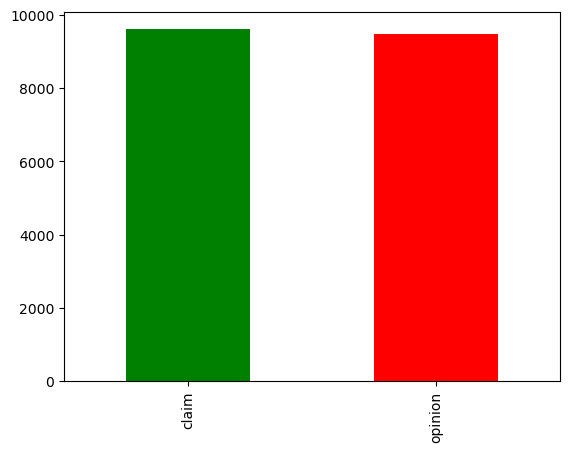

In [11]:
#visualizing class balance
df0['claim_status'].value_counts().plot.bar(color=['green', 'red'])

Great , the target variable is balanced

### Feature Engineering

#### Feature Extraction

In [12]:
#Creating a new column for each post text length
df0['text_length'] = df0['video_transcription_text'].str.len()
df0.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


#### **Feature selection and transformation**

#### let's now encode our categorical variables

In [13]:
# Drop unnecessary columns
df0 = df0.drop(['#', 'video_id'], axis=1)
# Encode target variable
df0['claim_status'] = df0['claim_status'].replace({'opinion': 0, 'claim': 1})
# Dummy encode remaining categorical values
df0 = pd.get_dummies(df0,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True)
df0.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0


# paCe: Construct Stage

## Step 3. Model Building

This is a classification task , since our target variable is categorical consisting of 0 and 1. 

we will proceed with five classifiers:
 - Naive Bayes
 - Random Forest
 - XGBOOST

### Modeling

In [15]:
# Identifying features and target variable
X = df0.drop(['claim_status'] , axis = 1)
y = df0['claim_status']

X.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0


In [16]:
# Split dataset into training , validating holdout(test) datasets

#creating Training and testing sets
X_train , X_test , y_train , y_test = train_test_split(X, y , test_size = 0.3 , stratify=y , random_state = 42)

#creating a validation set
X_tr , X_val , y_tr , y_val = train_test_split(X_train, y_train , test_size = 0.5,  stratify=y_train , random_state = 10)

Let's illustrate what we are doing here , simply we are splitting our dataset to training and testing set as normal , but we want to apply the **cross validation** technique , which means that we will train our model using the training data as normal , but we won't check the model accuracy on the test data , instead we will use our validation set to train all the models we are going to experiment.
now the question is what should be done with the test data 🤔 ????!
the test data will remain unseen until we finish building all the models , finally the champion model (the model with higher accuracy scores) will only be used to predict on the testing data 😎.
the following diagram illustrates the idea. 

Note: it's not a must to split the data 60 20 20 , in our case here , we are splitting it to 70 15 15



### Tokenize video_transcription_text column

In [17]:
# Setting up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [18]:
# Extract numerical features from `video_transcription_text` in the training set
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [19]:
# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

# Display first few rows
count_df.head()

,colleague learned,colleague read,discussion board,friend learned,friend read,internet forum,learned media,learned news,learned website,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
# Concatenate `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_train after dropping `video_transcription_text`,
# so that the indices align with those in `X_train` and `count_df`
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

# Display first few rows
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,internet forum,learned media,learned news,learned website,media claim,news claim,point view,read media,social media,willing wager
0,7,9196.0,2665.0,692.0,64.0,9.0,105,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,39,9117.0,3613.0,722.0,87.0,2.0,73,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,51,560.0,116.0,19.0,2.0,0.0,73,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11,729.0,96.0,8.0,0.0,0.0,58,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,16,921.0,55.0,19.0,1.0,0.0,73,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
#Get n-gram counts for the validation data
# Extract numerical features from `video_transcription_text` in the testing set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [22]:
# Place the numerical representation of `video_transcription_text` from validation set into a dataframe
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()

,colleague learned,colleague read,discussion board,friend learned,friend read,internet forum,learned media,learned news,learned website,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [23]:
# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_val after dropping `video_transcription_text`,
# so that the indices align with those in `validation_count_df`
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)

# Display first few rows
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,internet forum,learned media,learned news,learned website,media claim,news claim,point view,read media,social media,willing wager
0,42,9121.0,2284.0,838.0,51.0,18.0,128,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,35,2855.0,498.0,174.0,5.0,1.0,72,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13,4422.0,1777.0,410.0,10.0,3.0,87,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,59,854106.0,421844.0,59824.0,6990.0,4563.0,110,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,52,69637.0,42889.0,1716.0,761.0,402.0,113,1,0,0,...,0,0,1,0,0,1,0,0,0,0


In [24]:
# Extract numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from test set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,internet forum,learned media,learned news,learned website,media claim,news claim,point view,read media,social media,willing wager
0,11,942198.0,146824.0,57218.0,1845.0,1102.0,87,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,35,609678.0,368571.0,38783.0,383.0,154.0,55,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11,391243.0,253833.0,6367.0,3187.0,1315.0,112,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16,342194.0,222292.0,83803.0,381.0,77.0,90,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,27,149191.0,28815.0,10956.0,715.0,257.0,82,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Experiment 1: Naive Bayes

There different types of Naive bayes algorithms to be used here , they are :

**BernoulliNB**: Used for binary/Boolean features 

**CategoricalNB**: Used for categorical features

**ComplementNB**: Used for imbalanced datasets, often for text classification tasks

**GaussianNB**: Used for continuous features, normally distributed features

**MultinomialNB**: Used for multinomial (discrete) features

Since our features are continous , we will use gaussian NB

In [25]:
# Training a Naive Bayes Classifier
Naive_model = GaussianNB().fit(X_train_final , y_train)

#### We are going to use the confusion matrix & accuracy measures to test the accuracy of each model we will create , so let's create a function that takes three arguments , model , x_data and y_data , to prevent code duplication

In [26]:
#creating a confusion matrix to identify how accurate our classifier is
def conf_matrix_plot(model, x_data, y_data):
    model_pred = model.predict(x_data) # Save predictions
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_) # Calculate the values for each quadrant in the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot(values_format='')  # `values_format=''` this is written to prevent the numbers in the confusion matrix to appear in that form (1.5e+03) 
    plt.show()    
    
    #Accuracy reports
    report =    {"Accuracy" :accuracy_score(y_data, model_pred) , 
                "Precision": precision_score(y_data, model_pred),
                "Recall" : recall_score(y_data, model_pred) , 
                "F1 Score" : f1_score(y_data, model_pred)}
    for key , value  in report.items():
        print(f"{key}:{value.round(3)}")

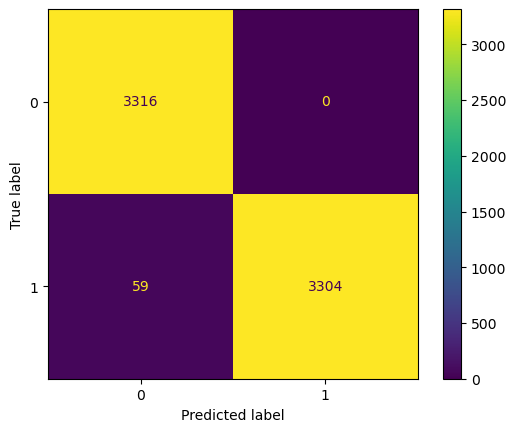

Accuracy:0.991
Precision:1.0
Recall:0.982
F1 Score:0.991


In [27]:
conf_matrix_plot(Naive_model, X_val_final, y_val)

## Experiment 2: Random Forest

#### We should first first identify the best Hyper paramaters for the classifier using GridSearch

In [28]:
# Instantiate random forest model.
rf = RandomForestClassifier()

In [29]:
# Determine set of hyperparameters for random forest
rf_cv_params = {'n_estimators' : [50,100 , 150 , 200], 
              'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50],
             'min_samples_leaf': [2, 5, 10, 20, 50],
             'min_samples_split': [2, 4, 6],
              'max_features' : ["sqrt"], 
              'max_samples' : [.5,.9]}

scoring = {'accuracy', 'precision', 'recall', 'f1'}

GridSearchCV wants to cross validate the data. In fact, if the CV parameter was left blank, it would split the data into five folds for cross-validation by default. Because we are using a separate validation set, it's important to explicitly tell the function how to perform the validation. This includes telling it every row in the training and testing sets. we will use a **list comprehension** to generate a list of the same length as our X_tr data, where each value is either a negative one or a zero. Use this list to indicate to GridSearchCV that each row labeled negative 1 is in the training set and each row labeled as zero is in the validation set.

In [30]:
# Create list of split indices.
split_index = [0 if x in X_val_final.index else -1 for x in X_train_final.index]
custom_split = PredefinedSplit(split_index)

In [31]:
%time 
rf_val = GridSearchCV(rf, rf_cv_params, cv=custom_split, refit='recall', n_jobs = -1, verbose = 1)

# Fit the model
rf_val.fit(X_train_final , y_train)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 1 folds for each of 1680 candidates, totalling 1680 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([ 0,  0, ..., -1, -1])),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50],
                         'max_features': ['sqrt'], 'max_samples': [0.5, 0.9],
                         'min_samples_leaf': [2, 5, 10, 20, 50],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [50, 100, 150, 200]},
             refit='recall', verbose=1)

In [32]:
#getting the best paramaters to be used with Random forest
rf_val.best_params_

{'max_depth': 20,
 'max_features': 'sqrt',
 'max_samples': 0.9,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50}

In [33]:
rf_model = RandomForestClassifier(max_depth = 20 , max_features =  'sqrt' , 
                                  max_samples = 0.9, min_samples_leaf = 2, min_samples_split = 2 , n_estimators =  50 ).fit(X_train_final , y_train)

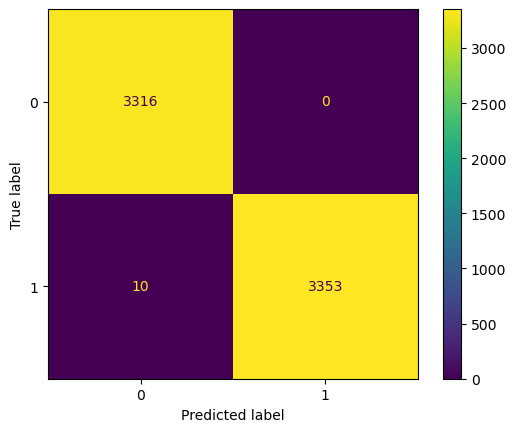

Accuracy:0.999
Precision:1.0
Recall:0.997
F1 Score:0.999


In [34]:
conf_matrix_plot(rf_model, X_val_final, y_val)

## Experiment 3: Gradient boosting (XGBOOST)

#### In this experiment , let's use another tree-based ensemble model  ,  XGBOOST  

In [38]:
#Instantiate XGBOOST classifier
xgb = XGBClassifier(objective='binary:logistic' , random_state=0)

In [49]:
# Determine set of hyperparameters for XGBOOST
xgb_cv_params = {'max_depth': [4, 6],
              'min_child_weight': [3, 5],
              'learning_rate': [0.1, 0.2, 0.3],
              'n_estimators': [5,10,15],
              'subsample': [0.7],
              'colsample_bytree': [0.7]
              }

scoring = ['accuracy', 'precision', 'recall', 'f1']

In [50]:
%%time
xgb_cv = GridSearchCV(xgb,
                      xgb_cv_params,
                      scoring = scoring,
                      cv = custom_split,
                      refit = 'recall'
                     )

# Fit the model
xgb_cv.fit(X_train_final, y_train)

CPU times: total: 10.3 s
Wall time: 999 ms


GridSearchCV(cv=PredefinedSplit(test_fold=array([ 0,  0, ..., -1, -1])),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [4, 6],
                         'min_child_weight': [3, 5],
                         'n_estimators': [5, 10, 15], 'subsample': [0.7]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [59]:
#getting the best paramaters to be used with XGBOOST
xgb_cv.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 15,
 'subsample': 0.7}

In [53]:
#Training XGBOOST model with the best hyperparamters
xg_model = XGBClassifier(colsample_bytree =  0.7,
 learning_rate= 0.2,
 max_depth=  4,
 min_child_weight =  3,
 n_estimators = 15,
 subsample = 0.7).fit(X_train_final , y_train)

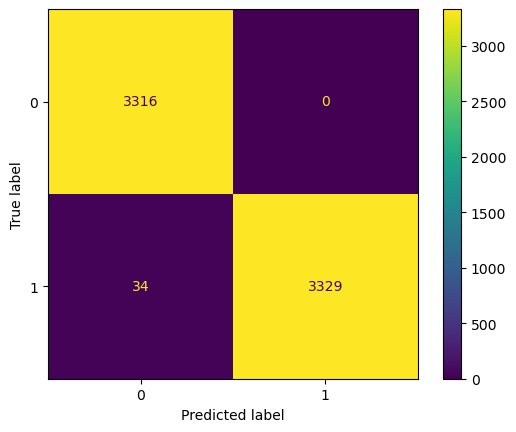

Accuracy:0.995
Precision:1.0
Recall:0.99
F1 Score:0.995


In [60]:
conf_matrix_plot(xg_model, X_val_final, y_val)

# pacE: Execute Stage

## Step 4. Results and Evaluation

### Summary of model results

#### let's Compare all the alogtithms used together to identify the Champion model

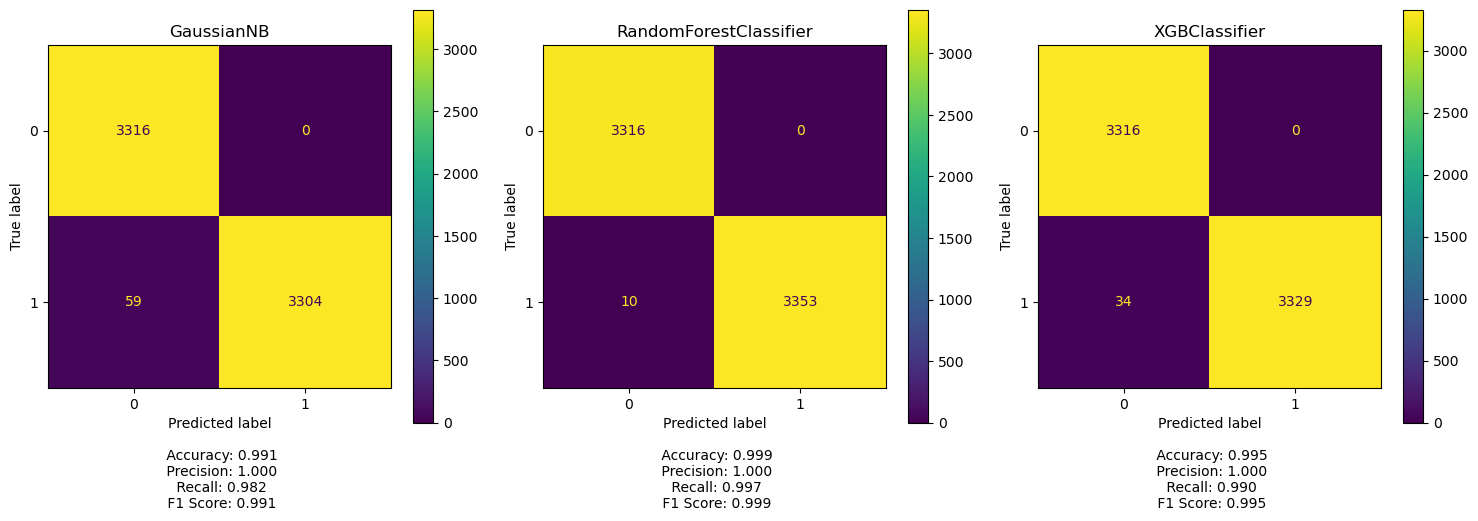

In [57]:
# Collecting our classifiers in a list
classifiers = [Naive_model, rf_model, xg_model]

# Create a grid of subplots to compare the confusion matrices and accuracy measures
num_classifiers = len(classifiers)

fig, axes = plt.subplots(1, num_classifiers, figsize=(5 * num_classifiers, 5))

# Iterate over each classifier and display its confusion matrix along with its accuracy measures
for i, model in enumerate(classifiers):
    # Compute the confusion matrix
    y_pred = model.predict(X_val_final)
    cm = confusion_matrix(y_val, y_pred, labels=model.classes_)
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=axes[i], values_format='')
    axes[i].set_title(model.__class__.__name__)  # Set the title to the classifier name
    
    # Compute accuracy measures
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Add text annotations for accuracy measures
    textstr = f' \n \n \n \n \n Accuracy: {acc:.3f}\n Precision: {prec:.3f}\n Recall: {rec:.3f}\n F1 Score: {f1:.3f}'
    axes[i].text(0.5, -0.15, textstr, horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)

plt.tight_layout()
plt.show()


# By comparing the results of the three classifiers used , the champion model with recall 0.997 ,  is **RandomForest** 🏆🥇

Finally , let's look at the random forest feature importance to identify which features were the most useful for the champion model (random forest)

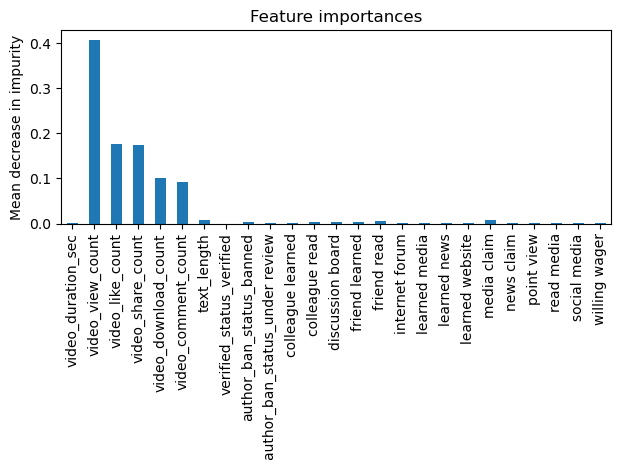

In [62]:
importances = rf_val.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

**video_view_count** , **video_like_count** , **video_share_count** , **video_download_count** and **video_comment_count** are the most effective features for random forest classifier

Now let's evaluate the champion model on the unseen test set

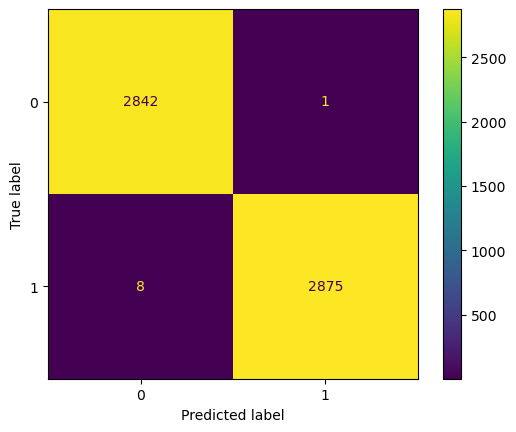

Accuracy:0.998
Precision:1.0
Recall:0.997
F1 Score:0.998


In [65]:
conf_matrix_plot(rf_model, X_test_final, y_test)

Great Recall !! ♥️

### Conclusion, Recommendations

- The model performed well on both the validation and test holdout data. Furthermore, both precision and F1 scores were consistently high. The model very successfully classified claims and opinions.

- The model's most predictive features were all related to the user engagement levels associated with each video. It was classifying videos based on how many views, likes, shares, comments ,and downloads they received.